In [138]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress bar
from audioMNIST import AudioMNIST
from DClassifier import CNN2DAudioClassifier
from RNNClassifier import SimpleGRU
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

In [139]:
file_paths = './data/'

In [140]:
if torch.cuda.is_available():
    print("Using CUDA device")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device('cpu')

Using CPU


In [141]:
def evaluate(model, val_dl): 
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
        
    for data in tqdm(val_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    num_batches = len(val_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    return acc, avg_loss

In [142]:
# Training
def training(model, train_dl, val_dl, num_epochs, 
             criterion, optimizer, scheduler):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        for data in tqdm(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        v_acc, v_loss = evaluate(model.to(device), val_dl)
        
        print("Epoch: %d, Loss: %.4f, Train Accuracy: %.2f, Val. Loss: %.4f, Val. Accuracy: %.2f" % (
            epoch + 1, avg_loss, acc, v_loss, v_acc
        ))
        
        losses.append(avg_loss)
        val_losses.append(v_loss)
        
    return losses, val_losses

In [143]:
if __name__ == '__main__':
    # dataset
    dataset = AudioMNIST()

    # Calculate sizes for 60-20-20 split
    n_total = len(dataset)
    n_train = int(n_total * 0.6)
    n_val = int(n_total * 0.2)
    n_test = n_total - n_train - n_val

    # Split the dataset
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    # DataLoader instances
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


In [144]:
# model
input_size = 13 
hidden_size = 64
num_layers = 1
num_classes = 10
model = SimpleGRU(input_size, hidden_size, num_layers, num_classes).to(device)

N_EPOCHS = 12

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001, 
                                                steps_per_epoch=int(len(train_dl)), 
                                                epochs=N_EPOCHS, 
                                                anneal_strategy='linear')

# TRAIN
losses, val_losses = training(model, train_dl, val_dl, N_EPOCHS, criterion, optimizer, scheduler)


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 1, Loss: 2.2853, Train Accuracy: 0.15, Val. Loss: 2.1843, Val. Accuracy: 0.27


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 2, Loss: 1.6563, Train Accuracy: 0.39, Val. Loss: 1.3747, Val. Accuracy: 0.51


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 3, Loss: 1.0039, Train Accuracy: 0.64, Val. Loss: 0.8457, Val. Accuracy: 0.70


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 4, Loss: 0.6623, Train Accuracy: 0.77, Val. Loss: 0.5766, Val. Accuracy: 0.81


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 5, Loss: 0.3751, Train Accuracy: 0.88, Val. Loss: 0.2808, Val. Accuracy: 0.91


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 6, Loss: 0.2152, Train Accuracy: 0.94, Val. Loss: 0.1772, Val. Accuracy: 0.95


100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Epoch: 7, Loss: 0.1545, Train Accuracy: 0.95, Val. Loss: 0.1416, Val. Accuracy: 0.96


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 8, Loss: 0.1232, Train Accuracy: 0.96, Val. Loss: 0.1139, Val. Accuracy: 0.97


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 9, Loss: 0.1022, Train Accuracy: 0.97, Val. Loss: 0.1027, Val. Accuracy: 0.97


100%|██████████| 94/94 [00:30<00:00,  3.03it/s]


Epoch: 10, Loss: 0.0939, Train Accuracy: 0.97, Val. Loss: 0.0917, Val. Accuracy: 0.97


100%|██████████| 94/94 [00:38<00:00,  2.45it/s]


Epoch: 11, Loss: 0.0833, Train Accuracy: 0.98, Val. Loss: 0.0795, Val. Accuracy: 0.98


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]

Epoch: 12, Loss: 0.0767, Train Accuracy: 0.98, Val. Loss: 0.0761, Val. Accuracy: 0.98


In [145]:
def final_evaluate(model, test_dl):
    model.eval()

    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    all_labels = []
    all_predictions = []

    for data in tqdm(test_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()

        _, predictions = torch.max(outputs, 1)
        correct_prediction += (predictions == labels).sum().item()
        total_prediction += predictions.shape[0]

        # labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    num_batches = len(test_dl)
    avg_loss = running_loss / num_batches
    accuracy = correct_prediction / total_prediction
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

    # compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {accuracy:.4f}, Macro F1 Score: {f1_macro:.4f}, Average Loss: {avg_loss:.4f}")

    return accuracy, f1_macro, avg_loss

100%|██████████| 188/188 [00:26<00:00,  7.08it/s]


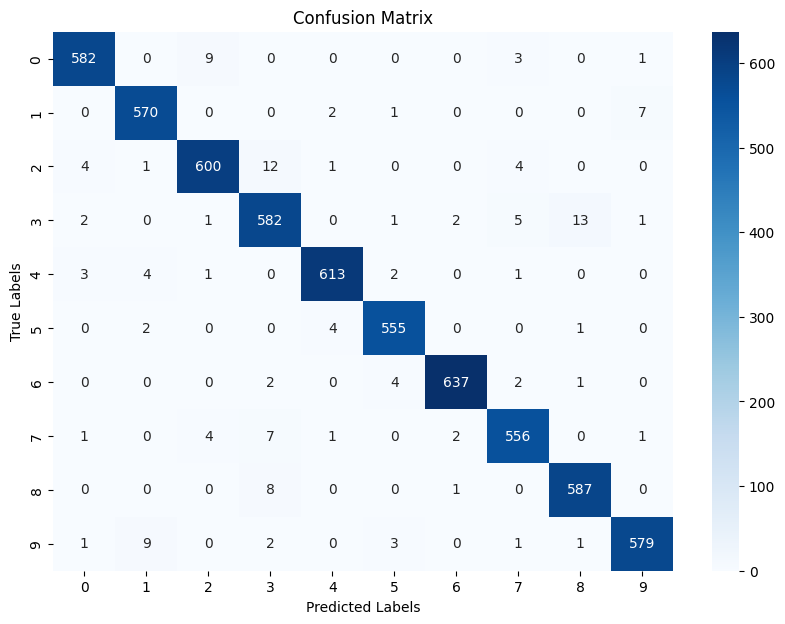

Accuracy: 0.9768, Macro F1 Score: 0.9768, Average Loss: 0.0826


ValueError: too many values to unpack (expected 2)

In [146]:
# EVAL
test_accuracy, test_f1 = final_evaluate(model, test_dl)